In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt


C:\Users\r02as18\miniconda3\envs\gempy\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


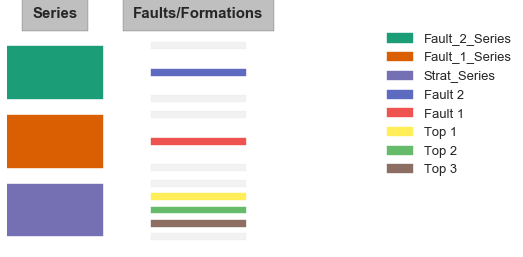

In [2]:
geo_model = gp.create_model('Model_Tuto1-1')

# Importing the data from CSV-files and setting extent and resolution
gp.init_data(geo_model, [0,3000.,0,2000.,0,2000.],[50,50,50], 
      path_o = os.pardir+"/../input_data/orient_abutting_faults.csv",
      path_i = os.pardir+"/../input_data/interfaces_abutting_faults.csv", default_values=True) 

gp.map_series_to_formations(geo_model, 
                            {"Fault_2_Series":'Fault 2',
                             "Fault_1_Series":'Fault 1', 
                             
                             "Strat_Series": ('Top 1', "Top 2", "Top 3", 'basement')}, 
                            remove_unused_series=True)

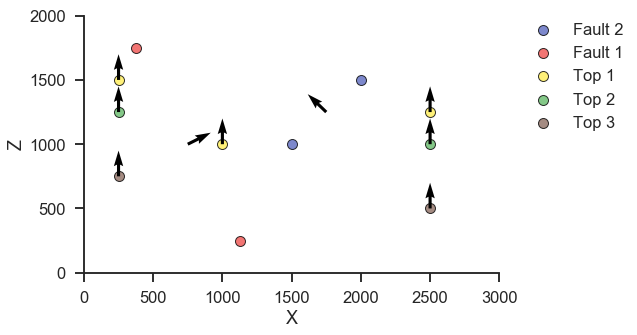

In [3]:
gp.plot.plot_data(geo_model)

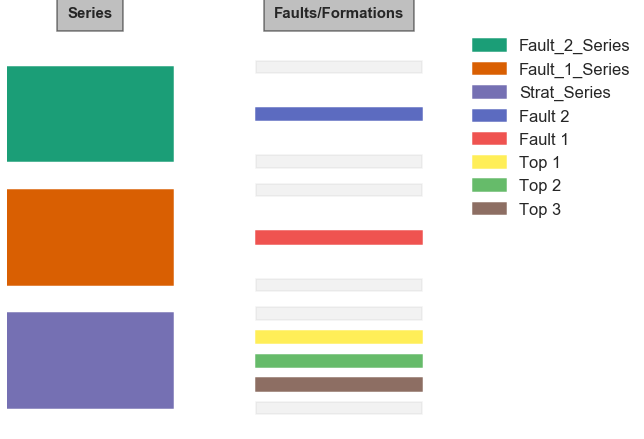

In [4]:
# geo_model.update_from_series()
geo_model.formations.update_sequential_pile()
geo_model.formations.sequential_pile.figure

In [6]:
geo_model.series

,order_series,BottomRelation
Fault_2_Series,1,Erosion
Fault_1_Series,2,Erosion
Strat_Series,3,Erosion


In [7]:
geo_model.set_is_fault(["Fault_1_Series"])
geo_model.set_is_fault(["Fault_2_Series"])

,isFault,isFinite
Fault_1_Series,True,False
Fault_2_Series,True,False
Strat_Series,False,False


#### Set fault relations

In [20]:
fault_rel = np.zeros((3,3))
print(fault_rel)
fault_rel[0,1] = 1
# fault_rel[1,0] = 1
print(fault_rel)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [21]:
geo_model.faults.set_fault_relation(fault_rel)

,Fault_1_Series,Fault_2_Series,Strat_Series
Fault_1_Series,False,True,False
Fault_2_Series,False,False,False
Strat_Series,False,False,False


#### Compile

In [35]:
gp.set_interpolation_data(geo_model,
                              output='geology', compile_theano=True,
                              theano_optimizer='fast_compile', verbose=[])
#                               verbose=['n_formation', 'faults_relation', 'fault_matrix_loop'])

Compiling theano function...
Compilation Done!


,values
dtype,float64
output,geology
theano_optimizer,fast_compile
device,cpu
verbosity,[]


#### Modify kriging parameters: Nugget effect

In [47]:
geo_model.modify_kriging_parameters("nugget grad", 1e13)
geo_model.update_to_interpolator()

In [48]:
geo_model.modify_kriging_parameters??

Signature: geo_model.modify_kriging_parameters(property, value)
Docstring: <no docstring>
Source:   
    def modify_kriging_parameters(self, property, value):
        self.additional_data.kriging_data.modify_kriging_parameters(property, value)
File:      c:\users\r02as18\git\gempy\gempy\core\model.py
Type:      method


In [43]:
sol = gp.compute_model(geo_model, compute_mesh=True)

C:\Users\r02as18\miniconda3\envs\gempy\lib\site-packages\theano\tensor\slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=8.33334e-27): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
C:\Users\r02as18\miniconda3\envs\gempy\lib\site-packages\theano\tensor\slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=2.11134e-33): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
C:\Users\r02as18\miniconda3\envs\gempy\lib\site-packages\theano\tensor\slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=2.52027e-26): result may not be accurate.
  rval = scipy.linalg.solve(A, b)


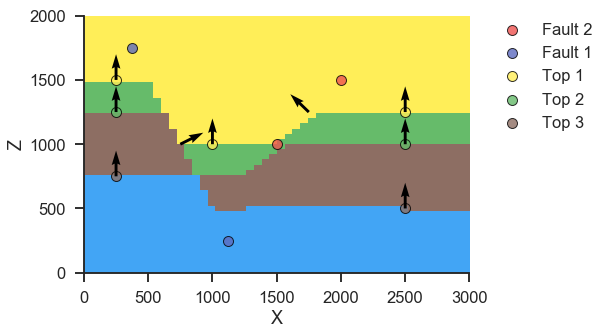

In [44]:
gp.plot.plot_section(geo_model, cell_number=25, plot_data=True)

In [45]:
ver , sim = gp.get_surfaces(geo_model)
gp.plot.plot_surfaces_3D(geo_model, list(ver.values()), list(sim.values()))

closing vtk


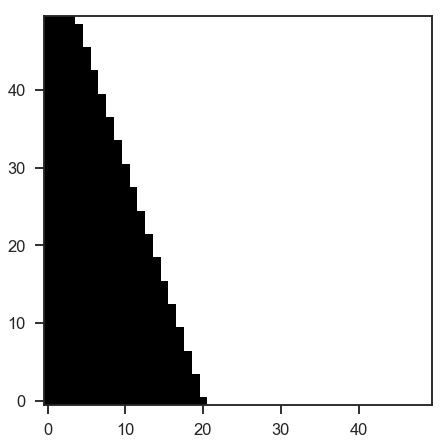

In [49]:
plt.imshow(geo_model.solutions.fault_blocks[0].reshape(50,50,50)[:,25,:].T, origin="lower")

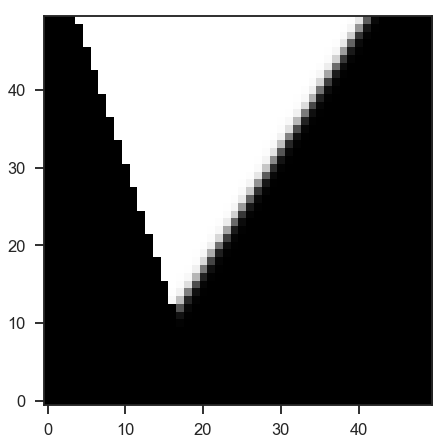

In [50]:
plt.imshow(geo_model.solutions.fault_blocks[1].reshape(50,50,50)[:,25,:].T, origin="lower")

In [52]:
geo_model.solutions


Lithology ids 
  [6. 6. 6. ... 3. 3. 3.] 
Lithology scalar field 
  [19.78694534 19.80472374 19.82250214 ... 20.73361778 20.75139427
 20.76917267] 
Fault block 
  [[2. 2. 2. ... 1. 1. 1.]
 [3. 3. 3. ... 3. 3. 3.]]

#### (hastily) fixed fault contour function

In [244]:
import matplotlib

def extract_countours(geo_data, cell_number, direction='y', lb=None):
    """
    To extract the boundaries between lithologies and plot faults as lines in 2D plots.
    Args: the same as gp.plotting.plot_section or plot_map
        geo_data:
        interp_data:
        fb: fault block
        lb: lithology block
        direction:
        cell_number:
    Returns: nothing, it just plots
    """
    fault_colors = ['#000000', '#000000', '#000000', '#000000', '#000000']
    #fault_colors=['#015482','#015482','#015482','#015482','#015482']
    cm_fault = matplotlib.colors.LinearSegmentedColormap.from_list('faults', fault_colors, N=5)
    lith_colors = ['#000000', '#000000', '#000000', '#000000', '#000000']
    cm_lith = matplotlib.colors.LinearSegmentedColormap.from_list('lith_colors', lith_colors, N=5)

    #n_faults = int(fb.shape[0] / 2)
    #level = []
    block_id = []

    all_levels = geo_data.solutions.scalar_field_at_interfaces[np.where(geo_data.solutions.scalar_field_at_interfaces != 0)]
    
    fb = geo_data.solutions.fault_blocks
#     lb = geo_data.solutions.lith_block
    for i in range(fb.shape[0]):
        if i % 2:
            block_id.append(i)

    if direction == 'y':
        _slice = np.s_[:, cell_number, :]
        extent = geo_data.grid.extent[[0, 1, 4, 5]]
    elif direction == 'x':
        _slice = np.s_[cell_number, :, :]
        extent = geo_data.grid.extent[[2, 3, 4, 5]]
    elif direction == 'z':
        _slice = np.s_[:, :, cell_number]
        extent = geo_data.grid.extent[[1,2, 3, 4]]
    else:
        print('not a direction')

    if fb is not None:
        for i in range(len(block_id)):
            plt.contour(fb[block_id[i]].reshape(geo_data.grid.resolution)[_slice].T, 0,
                        extent=extent, levels=all_levels[i], cmap=cm_fault)
#     if lb is not None:
#         plt.contour(lb.reshape(geo_data.grid.resolution)[_slice].T, 0,
#                     extent=extent, levels=np.sort(all_levels[len(block_id):]),
#                     cmap=cm_lith)

In [110]:
sf = geo_model.solutions.scalar_field_lith
sfai = geo_model.solutions.scalar_field_at_interfaces[1, 1:]  # contour levels representing the lith interfaces
sfai.sort()

In [ ]:
plt.contourf(sf.reshape(50,50,50)[:, 25,:].T, levels=sfai, cmap='YlOrRd_r', extend='both',
             extent=geo_model.grid.extent[[0,1,4,5]])